In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PATH_TRAIN = 'finetuning-train/images/'
PATH_TEST = 'finetuning-test/images/'

# Подготовка данных

Читаем картинки

In [2]:
from skimage.io import imread
import pandas as pd

images_train = []
for image_file_name in sorted(os.listdir(PATH_TRAIN)):
    images_train.append(imread(os.path.join(PATH_TRAIN, image_file_name)))
    
images_test = []
for image_file_name in sorted(os.listdir(PATH_TEST)):
    images_test.append(imread(os.path.join(PATH_TEST, image_file_name)))

Приводим к нужному шейпу

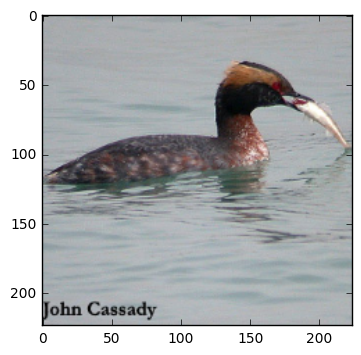

In [3]:
from skimage.color import gray2rgb
from skimage.util import crop
from skimage.transform import resize

IMAGE_SHAPE = (224, 224)

def get_resized(image):
    if len(image.shape) == 2:
        image = gray2rgb(image)
    height, width, colors = image.shape
    min_side = min(height, width)
    h_crop_width = (height - min_side) / 2
    w_crop_width = (width - min_side) / 2
    cropped = crop(image, [(h_crop_width, h_crop_width), (w_crop_width, w_crop_width), (0, 0)])
    return resize(cropped, IMAGE_SHAPE)

images_train = np.array(map(get_resized, images_train))
images_test = np.array(map(get_resized, images_test))

plt.imshow(images_train[42])
plt.show()

# Генерируем признаки при помощи предобученных нейросетей

Выбираем сетку для генерации фичей (при помощи форвард прохода).

Я прогонял одну сеть -> дропал фичи -> рестартил ноутбук -> прогонял другую сеть -> дропал фичи -> рестартил ноутбук -> загружал все фичи -> обучал модельки

In [4]:
NN_NAME='vgg16'
NN_NAME='resnet'

Ссылки на файлы с сетками:
* https://github.com/ry/tensorflow-vgg16
* https://github.com/fivejjs/tensorflow-resnet

In [5]:
import tensorflow as tf

with tf.device("/cpu:0"):
    batch_placeholder = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
    graph_def = tf.GraphDef()
    model_file_name = 'vgg16-20160129.tfmodel' if NN_NAME=='vgg16' else 'resnet-152-20160223.tfmodel'
    with open(model_file_name, 'rb') as model_file:
        model = model_file.read()
    graph_def.ParseFromString(model)
    tf.import_graph_def(graph_def, input_map={"images": batch_placeholder})
    graph = tf.get_default_graph()
    fc_layer = graph.get_tensor_by_name('import/{}'.format('Relu_1:0' if NN_NAME=='vgg16' else 'Squeeze:0'))
    
sess = tf.InteractiveSession()
tf.global_variables_initializer().run(session=sess)

In [6]:
%%time
BATCH_SIZE = 64

X_train = []
for i in xrange(0, images_train.shape[0], BATCH_SIZE):
    X_train.extend(sess.run(fc_layer, feed_dict={batch_placeholder: images_train[i : i + BATCH_SIZE]}))
X_train = np.array(X_train)

X_test = []
for i in xrange(0, images_test.shape[0], BATCH_SIZE):
    X_test.extend(sess.run(fc_layer, feed_dict={batch_placeholder: images_test[i : i + BATCH_SIZE]}))
X_test = np.array(X_test)

CPU times: user 2h 1min 18s, sys: 3min 53s, total: 2h 5min 11s
Wall time: 16min 9s


In [7]:
import cPickle

cPickle.dump(X_train, open('X_train_{}.pkl'.format(NN_NAME), 'wb'))
cPickle.dump(X_test, open('X_test_{}.pkl'.format(NN_NAME), 'wb'))

# Обучаем модельки

Загружаем фичи и тренировочные лейблы

In [2]:
import cPickle

X_train_vgg16 = cPickle.load(open('X_train_vgg16.pkl', 'rb'))
X_train_resnet = cPickle.load(open('X_train_resnet.pkl', 'rb'))
X_train = np.concatenate((X_train_vgg16, X_train_resnet), axis=1)

y_train = pd.read_csv('finetuning-train/gt.csv').class_id.values

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [20]:
%%time
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_tr, y_tr)
print accuracy_score(y_val, clf.predict(X_val))

0.774
CPU times: user 7.56 s, sys: 8 ms, total: 7.57 s
Wall time: 7.52 s


In [7]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_tr, y_tr)
print accuracy_score(y_val, clf.predict(X_val))

0.774
CPU times: user 45.8 s, sys: 104 ms, total: 45.9 s
Wall time: 45.8 s


In [4]:
%%time
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(normalize=True)
clf.fit(X_tr, y_tr)
print accuracy_score(y_val, clf.predict(X_val))

0.814
CPU times: user 2.09 s, sys: 508 ms, total: 2.6 s
Wall time: 1.09 s


In [16]:
%%time
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(n_iter=100)
clf.fit(X_tr, y_tr)
print accuracy_score(y_val, clf.predict(X_val))

0.75
CPU times: user 50.9 s, sys: 16 ms, total: 50.9 s
Wall time: 50.9 s


In [27]:
%%time
from xgboost import XGBClassifier

for d in (5, 7, 9):
    clf = XGBClassifier(max_depth=d)
    clf.fit(X_tr, y_tr)
    print accuracy_score(y_val, clf.predict(X_val))

0.726
0.728
0.73
CPU times: user 2h 27min 52s, sys: 1.53 s, total: 2h 27min 54s
Wall time: 18min 40s


RidgeClassifier показал лучшее качество и время работы. Попробуем затюнить его.

In [19]:
clf = RidgeClassifier(alpha=0.5, normalize=True)
clf = clf.fit(X_tr, y_tr)
print accuracy_score(y_val, clf.predict(X_val))

0.818


Уменьшили регуляризацию - стало чуть лучше на валидации.

# Получаем ответы на тестовой выборке

In [20]:
import cPickle

X_test_vgg16 = cPickle.load(open('X_test_vgg16.pkl', 'rb'))
X_test_resnet = cPickle.load(open('X_test_resnet.pkl', 'rb'))
X_test = np.concatenate((X_test_vgg16, X_test_resnet), axis=1)

In [24]:
clf = RidgeClassifier(alpha=0.5, normalize=True).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [25]:
pd.DataFrame({"filename": sorted(os.listdir(PATH_TEST)), "class_id": y_pred})\
.to_csv("answer_alpha05_alltrain.csv", index=False)